In [20]:
import cartopy, cartopy.crs as ccrs
import matplotlib, matplotlib.pyplot as plt
import numba, numpy as np, scipy as sp
import os, sys, re, pickle
import pandas as pd
import xarray as xr
import time
# Import local scripts
import accessor, derived, tc_analysis, utilities, visualization

import importlib
importlib.reload(derived);
importlib.reload(tc_analysis);
importlib.reload(utilities);
importlib.reload(visualization);

In [2]:
############################################################
# Begin numba-specific parallelization methods.

@numba.njit
def apply_along_axis_0(func1d, arr):
    """Like calling func1d(arr, axis=0)"""
    if arr.size == 0:
        raise RuntimeError("Must have arr.size > 0")
    ndim = arr.ndim
    if ndim == 0:
        raise RuntimeError("Must have ndim > 0")
    elif 1 == ndim:
        return func1d(arr)
    else:
        result_shape = arr.shape[1:]
        out = np.empty(result_shape, arr.dtype)
        _apply_along_axis_0(func1d, arr, out)
        return out

@numba.njit
def _apply_along_axis_0(func1d, arr, out):
    """Like calling func1d(arr, axis=0, out=out). Require arr to be 2d or bigger."""
    ndim = arr.ndim
    if ndim < 2:
        raise RuntimeError("_apply_along_axis_0 requires 2d array or bigger")
    elif ndim == 2:  # 2-dimensional case
        for i in range(len(out)):
            out[i] = func1d(arr[:, i])
    else:  # higher dimensional case
        for i, out_slice in enumerate(out):
            _apply_along_axis_0(func1d, arr[:, i], out_slice)

@numba.njit
def nb_mean_axis_0(arr):
    return apply_along_axis_0(np.nanmean, arr)
    
# End numba-specific parallelization methods.
############################################################

In [3]:
def data_access(model, domain, field, experiments=None, frequency='month', vertical_level=None, resample=True, years=[100, 150]):
    dirname = '/projects/GEOCLIM/gr7610/analysis/model_out'

    if not experiments:
        experiments = ['CTL1990s', 'CTL1990s_swishe']

    data, derived_field_list = {}, derived_fields()
    
    derived = False
    if field in derived_field_list.keys():
        derived = True
        for experiment in experiments:
            data[experiment] = {}
            for subfield in derived_field_list[field]['fields']:
                data[experiment][subfield] = None
                if 'swishe' in experiment:
                    # files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
                    #          (model in file) & (domain in file) & (f"var_{subfield}" in file) & (frequency in file) & 
                    #          ('swishe' in file) & ('resample' in file) & (file.endswith('nc')) & (str(min(years)) in file) & (str(max(years)) in file)]
                    files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
                             (model in file) & (domain in file) & (f"var_{subfield}" in file) & (frequency in file) & 
                             ('swishe' in file) & ('resample' in file) & (file.endswith('nc'))]
                    files = [f for f in files if
                             int(f.split('.nc')[0].split('-')[-1].split('_')[0]) <= min(years) and
                             int(f.split('.nc')[0].split('-')[-1].split('_')[1]) >= max(years)]
                    
                else:
                    # files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
                    #          (model in file) & (domain in file) & (f"var_{subfield}" in file) & (frequency in file) & ('ens_' not in file) &
                    #          ('swishe' not in file) & ('resample' in file) & (file.endswith('nc')) & (str(min(years)) in file) & (str(max(years)) in file)]
                    files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
                             (model in file) & (domain in file) & (f"var_{subfield}" in file) & (frequency in file) & ('ens_' not in file) &
                             ('swishe' not in file) & ('resample' in file) & (file.endswith('nc'))]
                    files = [f for f in files if
                             int(f.split('.nc')[0].split('-')[-1].split('_')[0]) <= min(years) and
                             int(f.split('.nc')[0].split('-')[-1].split('_')[1]) >= max(years)]
                
                # Select vertical level
                for file in sorted(files)[::-1]:
                    level_num = float(re.sub('\D', '', str(vertical_level))) if ((vertical_level) and (vertical_level != 'full')) else None
                    print('Level: {0}'.format(level_num))
                    if vertical_level and vertical_level in file:
                        data[experiment][subfield] = xr.open_dataset(file)
                        print('-->', file)
                    elif 'full' in file:
                        temp = xr.open_dataset(file)
                        if level_num:
                            if domain == 'atmos' and 'pfull' in temp.dims:
                                data[experiment][subfield] = temp.sel(pfull=level_num, method='nearest')
                            elif domain == 'ocean' and 'st_ocean' in temp.dims:
                                data[experiment][subfield] = temp.sel(st_ocean=level_num, method='nearest')
                        else:
                            data[experiment][subfield] = temp
                        print('-->', file)
                                
    else:
        for experiment in experiments:
            
            # files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
            #          (model in file) & (domain in file) & (field in file) & (frequency in file) & ('ens_' not in file) & 
                     # ('{0}-'.format(experiment) in file) & ('resample' in file) & (file.endswith('nc')) & (str(min(years)) in file) & (str(max(years)) in file)]
                     
            files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
                     (model in file) & (domain in file) & (field in file) & (frequency in file) & ('ens_' not in file) & 
                     ('{0}-'.format(experiment) in file) & ('resample' in file) & (file.endswith('nc'))]
            files = [f for f in files if
                     int(f.split('.nc')[0].split('-')[-1].split('_')[0]) <= min(years) and
                     int(f.split('.nc')[0].split('-')[-1].split('_')[1]) >= max(years)]

            print(experiment, files, vertical_level)

            start_year, end_year = ['{0:04d}-01-01'.format(min(years)), 
                                    '{0:04d}-01-01'.format(max(years))]
            
            # Select vertical level
            for file in sorted(files)[::-1]:
                level_num = float(re.sub('\D', '', str(vertical_level))) if ((vertical_level) and (vertical_level != 'full')) else None
                print('Level: {0}'.format(level_num))
                if vertical_level and str(vertical_level) in file:
                    data[experiment] = xr.open_dataset(file).sel(time=slice(start_year, end_year))
                    print('-->', file)
                elif 'full' in file:
                    temp = xr.open_dataset(file).sel(time=slice(start_year, end_year))
                    if level_num:
                        if domain == 'atmos' and 'pfull' in temp.dims:
                            data[experiment] = temp.sel(pfull=level_num, method='nearest')
                        elif domain == 'ocean' and 'st_ocean' in temp.dims:
                            data[experiment] = temp.sel(st_ocean=level_num, method='nearest')
                    else:
                        data[experiment] = temp
                    print('Experiment {0} --> file: {1}\n'.format(experiment, file))

            if domain == 'ocean':
                data[experiment]['xt_ocean'] = np.where(data[experiment].xt_ocean < 0, 
                                                        data[experiment].xt_ocean + 360, 
                                                        data[experiment].xt_ocean)
                data[experiment] = data[experiment].sortby('xt_ocean')
                if 'st_ocean' in data[experiment].dims:
                    data[experiment] = data[experiment].rename({'xt_ocean': 'grid_xt', 'yt_ocean': 'grid_yt', 'st_ocean': 'pfull'})
                else:
                    data[experiment] = data[experiment].rename({'xt_ocean': 'grid_xt', 'yt_ocean': 'grid_yt'})
    
    return data, derived

In [4]:
def bootstrap_3d(a, b, plane=None, N=1000, level=0.95):
    '''
    Method to run bootstrap statistical testing on 3-dimensional model output. Dimensions include time, grid_xt (longitude), grid_yt (latitude).
    Current method diagnoses difference in means and establishes statistical significance for a given level from 0 to 1.
    Uses a 2-tailed approach.
    Parallel approach produces a speedup of ~4x.
    See Delsole and Tippett (2013), Chapter 3.6 for details.
    '''

    # Make sure timestamps are the same among datasets by getting union of timestamps
    timestamp_union = list(set(a.time.values) & set(b.time.values))
    a, b = a.sel(time=list(timestamp_union)), b.sel(time=list(timestamp_union))
    
    # Extract correct dimensions by checking to make sure data dimensions
    for dataset in [a, b]:
        print(dataset.dims)
        # x-y planar data
        if ((plane == 'xy') or (plane is None)) and ('grid_xt' in dataset.dims) and ('grid_yt' in dataset.dims) and ('time' in dataset.dims):
            time_axis, x_axis, y_axis = a.dims.index('time'), a.dims.index('grid_xt'), a.dims.index('grid_yt')
        # y-z planar data 
        elif (plane == 'yz') and ('grid_yt' in dataset.dims) and ('pfull' in dataset.dims) and ('time' in dataset.dims):
            time_axis, x_axis, y_axis = a.dims.index('time'), a.dims.index('pfull'), a.dims.index('grid_yt')
        # x-z planar data
        elif (plane == 'xz') and ('grid_xt' in dataset.dims) and ('pfull' in dataset.dims) and ('time' in dataset.dims):
            time_axis, x_axis, y_axis = a.dims.index('time'), a.dims.index('grid_xt'), a.dims.index('pfull')
        else:
            print('Incorrect dimensions provided. Please check data for correct dimensions.')
            return None
            
    # Extract numeric values from the xArray Datasets
    x, y = a.values, b.values
    # Initialize empty arrays to contain output data
    out_x, out_y = [np.full((N, x.shape[y_axis], x.shape[x_axis]), np.nan), 
                    np.full((N, y.shape[y_axis], y.shape[x_axis]), np.nan)]

    @numba.njit(parallel=True)
    def bootstrap_resample(in_x, in_y, out_x, out_y, N):
        for repetition in numba.prange(0, N):
            out_x_temp, out_y_temp = np.full(in_x.shape, np.nan, dtype=np.float32), np.full(in_y.shape, np.nan, dtype=np.float32)
            for k in range(0, in_x.shape[time_axis]):
                out_x_temp[k] = in_x[np.random.randint(0, in_x.shape[time_axis]), :, :]
                out_y_temp[k] = in_y[np.random.randint(0, in_y.shape[time_axis]), :, :]
            out_x[repetition, :, :] = nb_mean_axis_0(out_x_temp)
            out_y[repetition, :, :] = nb_mean_axis_0(out_y_temp)
        return out_x, out_y
        
    out_x, out_y = bootstrap_resample(x, y, out_x, out_y, N)
    
    # Get difference between datasets
    delta = out_x - out_y # Control - SWISHE
    # Get values at each respective tail 
    ci_min, ci_max = np.quantile(delta, (1 - level)/2, axis=0), np.quantile(delta, (1 + level)/2, axis=0)
    # Wherever the signs are equal, output the mean. 
    # This indicates that the confidence interval does not intersect 0, such that the null hypothesis is rejected.
    out_binary = np.where(np.sign(ci_min) == np.sign(ci_max), 1, np.nan).T
    out_full = np.where(np.sign(ci_min) == np.sign(ci_max), np.nanmedian(delta, axis=0), np.nan).T
    median = np.nanmedian(delta, axis=0).T

    return out_binary, out_full, median, delta, ci_min, ci_max

In [5]:
def derived_fields():
    
    fields = {'p-e': {'fields': ['precip', 'evap'],
                      'attrs': {'long_name': 'precipitation - evaporation',
                                'units': 'mm d^-1'}},
              'netsw_toa': {'fields': ['netrad_toa', 'olr'],
                          'attrs': {'long_name': 'net shortwave, top-of-atmosphere',
                                    'units': 'W m^-2'}},
              'theta_e': {'fields': ['sphum', 'temp'],
                          'attrs': {'long_name': 'equivalent potential temperature',
                                    'units': 'K'}},
              'vi_h': {'fields': ['sphum', 'temp'],
                        'attrs': {'long_name': 'vertically-integrated moist static energy',
                                  'units': 'J kg^-1'}},
              'net_lw': {'fields': ['olr', 'lwdn_sfc', 'lwup_sfc'],
                         'attrs': {'long_name': 'net longwave radiation into atmosphere',
                                   'units': 'W m^{-2}'}},
              'swabs_toa': {'fields': ['swdn_toa', 'swup_toa'],
                         'attrs': {'long_name': 'net shortwave radiation into atmosphere',
                                   'units': 'W m^{-2}'}},
              'net_sw': {'fields': ['swdn_toa', 'swup_toa', 'swdn_sfc', 'swup_sfc'],
                         'attrs': {'long_name': 'net shortwave radiation into atmosphere',
                                   'units': 'W m^{-2}'}},
              'lp': {'fields': ['precip'],
                     'attrs': {'long_name': 'latent heating of condensation',
                                   'units': 'W m^{-2}'}},
              'q_atm': {'fields': ['precip', 'shflx', 'swdn_toa', 'swup_toa', 'olr', 'lwdn_sfc', 'lwup_sfc', 'swdn_sfc', 'swup_sfc'],
                      'attrs': {'long_name': 'atmospheric heating',
                                'units': 'W m^{-2}'}}}
    return fields 

In [6]:
def prune(data, field, vertical_level=None, plane='xy', extent=None, months=(1, 13), coarsen_factor=None):
    start_month, end_month = min(months), max(months)
    if not extent:
        extent = {'min_lon': 0, 'max_lon': 359, 'min_lat': -60, 'max_lat': 60}
    if not coarsen_factor:
        coarsen_factor = {'x': 2, 'y': 2, 'z': 1}
    if not vertical_level and plane == 'xy':
        vertical_level = 500
        print('Using default pressure level of 500 hPa...')

    outputs = {}
    derived_field_list = derived_fields()
    for experiment in data.keys():
        fields = [f if field in derived_field_list.keys() else field for f in data[experiment].keys()]
        outputs[experiment] = {}
        for subfield in fields:
            if 'pfull' in data[experiment][subfield].dims:
                if plane == 'xy':
                    outputs[experiment][subfield] = data[experiment][subfield].sel(grid_xt=slice(extent['min_lon'], extent['max_lon'])).sel(grid_yt=slice(extent['min_lat'], extent['max_lat'])).sel(pfull=vertical_level, method='nearest').sel(time=utilities.month_selector(data[experiment][subfield]['time.month'], start_month, end_month)).coarsen(grid_xt=coarsen_factor['x'], grid_yt=coarsen_factor['y']).mean()
                    outputs[experiment][subfield] = outputs[experiment][subfield].transpose('time', 'grid_yt', 'grid_xt').drop_duplicates('time')
                elif plane == 'yz':
                    outputs[experiment][subfield] = data[experiment][subfield].sel(grid_xt=slice(extent['min_lon'], extent['max_lon'])).mean(dim='grid_xt').sel(grid_yt=slice(extent['min_lat'], extent['max_lat'])).sel(time=utilities.month_selector(data[experiment][subfield]['time.month'], start_month, end_month)).coarsen(grid_yt=coarsen_factor['y'], pfull=coarsen_factor['z']).mean()
                    outputs[experiment][subfield] = outputs[experiment][subfield].transpose('time', 'grid_yt', 'pfull').drop_duplicates('time')
                elif plane == 'xz':
                    outputs[experiment][subfield] = data[experiment][subfield].sel(grid_xt=slice(extent['min_lon'], extent['max_lon'])).mean(dim='grid_yt').sel(time=utilities.month_selector(data[experiment][subfield]['time.month'], start_month, end_month)).coarsen(grid_xt=coarsen_factor['x'], pfull=coarsen_factor['z']).mean()
                    outputs[experiment][subfield] = outputs[experiment][subfield].transpose('time', 'grid_xt', 'pfull').drop_duplicates('time')
            else:
                outputs[experiment][subfield] = data[experiment][subfield].sel(grid_xt=slice(extent['min_lon'], extent['max_lon']), grid_yt=slice(extent['min_lat'], extent['max_lat'])).sel(time=utilities.month_selector(data[experiment][subfield]['time.month'], start_month, end_month)).coarsen(grid_xt=coarsen_factor['x'], grid_yt=coarsen_factor['y'], boundary='trim').mean().drop_duplicates('time')
        outputs[experiment] = xr.merge(outputs[experiment].values())
    return outputs

In [7]:
def derivation(data, field, plane='xy'):
    
    derived_fields_list = derived_fields()
    outputs = {}

    L = utilities.get_constants('L_v')
    
    for experiment in data.keys():
        outputs[experiment] = {}
        if field == 'p-e':
            outputs[experiment][field] = data[experiment]['precip'] - data[experiment]['evap']
        elif field == 'vi_h':
            data = derived.rh(data)
            data = derived.mse(data)
            outputs[experiment][field] = derived.vertical_integral(data, 'h')
        elif field == 'net_lw':  
            outputs[experiment][field] = data[experiment]['lwup_sfc'] - data[experiment]['olr'] - data[experiment]['lwdn_sfc']
        elif field == 'net_sw':  
            outputs[experiment][field] = data[experiment]['swdn_toa'] - data[experiment]['swup_toa'] - data[experiment]['swdn_sfc'] + data[experiment]['swup_sfc']
        elif field == 'swabs_toa':
            outputs[experiment][field] = data[experiment]['swdn_toa'] - data[experiment]['swup_toa']
        elif field == 'lp':
            outputs[experiment][field] = L * data[experiment]['precip']
        elif field == 'q_atm':
            outputs[experiment][field] = L * data[experiment]['precip'] + data[experiment]['shflx'] + data[experiment]['swdn_toa'] - data[experiment]['swup_toa'] - data[experiment]['swdn_sfc'] + data[experiment]['swup_sfc'] + data[experiment]['lwup_sfc'] - data[experiment]['olr'] - data[experiment]['lwdn_sfc'] 
        elif field == 'theta_e':
            R_d, R_v, L_v, c_pd, c_l = 287, 461.5, L, 1005.7, 4190

            # Define shorthand for variables
            p, q, t = data[experiment].pfull, data[experiment]['sphum'], data[experiment]['temp']
        
            eps = 0.622 # ratio of R_d to R_v
            # Get vapor pressure
            e = p/(eps/q - eps + 1)
            # Convert temperature
            tc = t - 273.16
            # Get saturation vapor pressure
            e_s = 6.112*np.exp(17.67*tc/(tc + 243.5))
            # Save to xArray DataArray
            data[experiment]['rh'] = 100*e/e_s
            data[experiment]['rh'].attrs = {'long_name': 'relative humidity', 'units': '%'}
            
            r = data[experiment]['sphum']/(1 - data[experiment]['sphum'])
            c_tot = (c_pd + c_l*r)
            a, b = R_d/c_tot, -r*R_v/c_tot
            outputs[experiment][field] = (data[experiment]['temp']*(1000/data[experiment]['temp'].pfull)**a) * (data[experiment]['rh']**b) * np.exp(L_v*r/(c_tot*data[experiment]['temp']))
            outputs[experiment][field] = outputs[experiment][field].where(outputs[experiment][field].pfull >= 85, np.nan)

            print(outputs[experiment][field].dims)
            
            outputs[experiment][field] = outputs[experiment][field].dropna(dim='time', how='all').dropna(dim='pfull', how='all')
        try:
            outputs[experiment][field].attrs = derived_fields_list[field]['attrs']
        except:
            print(outputs)

    return outputs

In [8]:
def xy_plot(model_name, data, median, significance_field, field, experiments, ci=None, outliers=True, years=None, months=None, 
            extent=None, vertical_level=None, contour_levels=13, track_overlay=True, domain_average=True, extrema=None, dpi=96, mask_over_land=False, 
            coarsen_factor=[1, 1, 1], stipple_color='light', cmap_white_fraction=0.1, experiment_name=None, savefig=False):

    importlib.reload(visualization)

    ''' Preload operations. '''
    # Define letters for subplot labeling
    letters = 'abcdefg'
    # Normalization factor to make moisture units more intuitive
    if field in ['precip', 'evap', 'p-e']:
        factor = 86400
    # Conversion to %
    elif field in ['cld_amt']:
        factor = 100
    else:
        factor = 1
    # Define year range
    year_min, year_max = min(years), max(years)
    # Define spatial extent
    min_lon, max_lon, min_lat, max_lat = extent[0], extent[1], extent[2], extent[3]
    # Create experiment name
    experiment_name = '{0} - {1}'.format(experiments[0], experiments[1])
    
    ''' Data loading. '''
    # Pull GCM experiment data
    data_control = {'mean': data[experiments[0]][field]*factor, 
                    'std': data[experiments[0]][field]*factor}
    data_swishe = {'mean': data[experiments[1]][field]*factor,
                    'std': data[experiments[1]][field]*factor}

    # Mask data over land, if boolean selected
    if mask_over_land:
        land_mask = xr.open_dataset('/projects2/GEOCLIM/gr7610/tools/land_mask.nc')['land_mask'].coarsen(grid_xt=coarsen_factor[0], 
                                                                                                         grid_yt=coarsen_factor[1]).mean().sel(grid_xt=slice(extent[0], extent[1])).sel(grid_yt=slice(extent[2], extent[3]))
        data[experiments[0]][field] = data[experiments[0]][field].where(land_mask == 0)
        data[experiments[1]][field] = data[experiments[1]][field].where(land_mask == 0)
        data_control['mean'] = data_control['mean'].where(land_mask == 0)
        data_swishe['mean'] = data_swishe['mean'].where(land_mask == 0)
        median = np.where(land_mask.T == 0, median, np.nan)
        
    ''' Figure setup. '''
    ncols = 3
    fig, grid = [plt.figure(dpi=dpi, figsize=(12, 2), constrained_layout=True), 
                 matplotlib.gridspec.GridSpec(nrows=1, ncols=ncols, width_ratios=(0.2, 0.2, 0.6), wspace=0.25, hspace=0)]
    # Define longitudinal offset
    longitude_offset = 180
    # Define projections (working and reference projections)
    proj, proj_ref = ccrs.PlateCarree(central_longitude=longitude_offset), ccrs.PlateCarree()

    # Pre-define metadata
    long_name, units = data[experiments[0]][field].attrs['long_name'], data[experiments[0]][field].attrs['units'] if field not in ['precip', 'evap', 'p-e'] else 'mm d$^{-1}$'
    long_name, units = visualization.field_properties(field)
    # Define month string to print
    months = range(min(months), max(months)+1)
    month_str = 'annual' if (months == None or (min(months) == 1 and max(months) == 12)) else ''.join([utilities.month_letter(month) for month in months])

    # Define line plot y-axis ticks
    y_step_major, y_step_minor = 20, 10
    gridline_y_major, gridline_y_minor = [np.arange(min_lat, max_lat + y_step_major, y_step_major), 
                                          np.arange(min_lat, max_lat + y_step_minor, y_step_minor)]

    
    # Iterate through subplots and define
    for i in range(0, ncols): 
        # Raw comparison
        if i == 0:
            ax = fig.add_subplot(grid[0, 0])
            ax.axhline(0, lw=0.5, alpha=0.5, c='k')
            # Plot line plots of zonal means
            im = ax.plot(data_control['mean'].mean(dim='grid_xt').mean(dim='time'), data_control['mean'].grid_yt, lw=2, c='b', ls='-', label=experiments[0])
            im = ax.plot(data_swishe['mean'].mean(dim='grid_xt').mean(dim='time'), data_swishe['mean'].grid_yt, lw=2, c='r', ls='--', label=experiments[1])
            # Plot formatting
            ax.set_ylim([min_lat, max_lat])
            ax.set_xlabel('{0} [{1}]'.format(field, units), labelpad=10)
            ax.set_ylabel('Latitude')
            ax.set_title('Zonal means', loc='left', fontsize=10)
            # Define ticks
            ax.set_yticks(gridline_y_major)
            # Set minor ticks
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(gridline_y_minor))
            ax.grid(alpha=0.25, ls='--', which='both')
            ax.annotate('({0})'.format(letters[i]), xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')

        # Difference
        elif i == 1:
            ax = fig.add_subplot(grid[0, 1])

            ax.axhline(0, lw=0.5, alpha=0.5, c='k')
            ax.axvline(0, lw=0.5, alpha=0.5, c='k')
            # Get difference
            delta = data[experiments[0]][field].mean(dim='grid_xt').mean(dim='time')*factor - data[experiments[1]][field].mean(dim='grid_xt').mean(dim='time')*factor
            # 5-degree rolling mean for 0.5-degree resolution data
            delta = delta.rolling(grid_yt=10, center=True).mean()
            ax.plot(delta, data[experiments[0]][field].grid_yt, lw=2, c='k')
            ax.set_xlabel('$\Delta$({0}) [{1}]'.format(field, units), labelpad=10)
            ax.set_title('Zonal mean difference', loc='left', fontsize=10)
            
            # Define ticks
            ax.set_yticks(gridline_y_major)
            # Set minor ticks
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(gridline_y_minor))
            ax.grid(alpha=0.25, ls='--', which='both')
            ax.annotate('({0})'.format(letters[i]), xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')
            ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

            # Plot track data for control and SWISHE
            track_ax = ax.inset_axes([1, 0, 0.2, 1])
            x_min, x_max = ax.get_xlim()
            visualization.TC_density_histogram(model_name, experiments, years, ax, month_range=months, orientation='horizontal')
            track_ax.set_ylim(ax.get_ylim())
            track_ax.set_axis_off()

        # 2D map
        else:
            # Initialize subplot
            level_str = '' if not vertical_level else ', {0}'.format(vertical_level)

            # Addendum string to indicate radiation budget sign convention
            radiation_direction = ''
            if field in ['netrad_toa', 'swup_sfc', 'swdn', 'netsw_toa']:
                radiation_direction = ', + down'
                median = np.where((data[experiments[0]][field].grid_xt >= 70) & (data[experiments[0]][field].grid_xt <= 110) &
                                  (data[experiments[0]][field].grid_yt >= 25) & (data[experiments[0]][field].grid_yt <= 40), np.nan, median)
            
            fig, grid, ax, proj_ref = visualization.basemap(fig, grid, model_name, '{3}{0} {1}{2}'.format(level_str, month_str, radiation_direction, experiment_name), year_range=(year_min, year_max),
                                                            row_num=0, col_num=2, extent=extent, land=True, ylabel=False, label_fontsize=10)
            
            ax = fig.add_subplot(grid[0, -1], projection=proj)

            ''' Filled contour plot. '''
            if not outliers:
                mean, std = np.nanmean(median), np.nanstd(median)
                median = np.where((median > (mean - 3*std)) & (median < (mean + 3*std)), median, np.nan)

            # Get colormap and normalization
            norm, cmap = visualization.norm_cmap(median, field, num_bounds=contour_levels, extrema=extrema, 
                                                 white_adjust=True, cmap_white_fraction=cmap_white_fraction)
            
            # Plot the data
            Z = xr.DataArray(data=median.T*factor, dims=['grid_xt', 'grid_yt']).rolling(grid_xt=4, center=True).mean().rolling(grid_yt=4, center=True).mean()
            im = ax.contourf(data[experiments[0]][field].grid_xt, data[experiments[0]][field].grid_yt, median.T*factor, 
                             cmap=cmap, norm=norm, levels=contour_levels, transform=proj_ref)
            
            X, Y = np.meshgrid(data[experiments[0]][field].grid_xt.values.ravel(), data[experiments[0]][field].grid_yt.values.ravel())
            stipple_cmap = 'Greys' if stipple_color == 'light' else 'Greys_r'
            stipple_alpha = 0.1 if 'omega' in field else 0.5
            ax.scatter(X.ravel()[::2], Y.ravel()[::2], c=significance_field.T.ravel()[::2], cmap=stipple_cmap, s=0.5,
                       linewidth=0.5, alpha=stipple_alpha, transform=ccrs.PlateCarree())
            ax.annotate('({0})'.format(letters[i]), xy=(0.01, 0.03), xycoords='axes fraction', ha='left', va='bottom')
            del X, Y

            
            ''' Track density plot. '''
            if track_overlay:
                ax = visualization.superimpose_TC_contour(model_name, experiments[0], years, ax, month_range=months)

            ''' Colorbar plotting. '''
            cax = ax.inset_axes([1.03, 0, 0.03, 1])
            colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
            
            colorbar.set_label('{0}\n[{1}]'.format(long_name, units), labelpad=30, rotation=270, fontsize=9)
            if field == 'sphum':
                cax.ticklabel_format(axis='both', style='sci', scilimits=(-3, 3))
                t = cax.yaxis.get_offset_text()
                t.set_x(1.5)
                t.set_fontsize(8)
            
            ax.coastlines()
            ax.add_feature(cartopy.feature.LAND, color=(0.5, 0.5, 0.5, 0.25), zorder=10)

            ax.set_extent(extent)

    # Figure saving
    if savefig:
        # Filename convention
        # model_{MODEL NAME}-result_{RESULT NAME}-type_{DOMAIN NAME}-var_{FIELD NAME}-level_{VERTICAL LEVEL}-years_s{START YEAR}_e{END YEAR}-months_s{START YEAR}_e{END YEAR}-ci_{CONFIDENCE INTERVAL}
        filename = 'model_{0}-result_{9}_{10}-type_{1}-var_{2}-mean_month-level-{3}-years_s{4}_e{5}-months_s{6}_e{7}-ci_{8}.png'.format(model, domain, field, vertical_level, 
                                                                                                                                        year_min, year_max, min(months), max(months)+1, ci, experiments[0], experiments[1])
        dirname = '/projects/GEOCLIM/gr7610/figs/climate'
        plt.savefig(os.path.join(dirname, filename), dpi=300, bbox_inches='tight')

In [9]:
def yz_plot(model_name, data, median, significance_field, field, ci=None, outliers=True, years=None, months=None, 
            extent=None, contour_levels=13, domain_average=True, extrema=None, dpi=96, 
            stipple_color='light', cmap_white_fraction=0.1, savefig=False):

    importlib.reload(visualization)

    # Define letters for subplot labeling
    letters = 'abcdefg'

    # Normalization factor to make moisture units more intuitive
    if field in ['precip', 'evap', 'p-e'] or ('tdt' in field) or ('qdt' in field):
        factor = 86400
        print(factor)
    elif field in ['cld_amt']:
        factor = 100
    else:
        factor = 1
    year_min, year_max = min(years), max(years)
    
    min_lon, max_lon, min_lat, max_lat = extent[0], extent[1], extent[2], extent[3]

    ncols = 3
    fig, grid = [plt.figure(dpi=dpi, figsize=(12, 2), constrained_layout=True), 
                 matplotlib.gridspec.GridSpec(nrows=1, ncols=ncols, width_ratios=(0.2, 0.2, 0.6), wspace=0.2, hspace=0)]
    
    data_control = {'mean': data[experiments[0]][field]*factor, 
                    'std': data[experiments[0]][field]*factor}
    data_swishe = {'mean': data[experiments[1]][field]*factor,
                    'std': data[experiments[1]][field]*factor}

    # Pre-define metadata
    long_name, units = visualization.field_properties(field)
    # Define month string to print
    months = range(min(months), max(months)+1)
    month_str = 'annual' if (months == None or (min(months) == 1 and max(months) == 12)) else ''.join([utilities.month_letter(month) for month in months])

    # Define line plot y-axis ticks
    y_step_major, y_step_minor = 100, 50
    gridline_y_major, gridline_y_minor = [np.arange(min_lat, max_lat + y_step_major, y_step_major), 
                                          np.arange(min_lat, max_lat + y_step_minor, y_step_minor)]
    # Iterate through subplots and define
    for i in range(0, ncols): 
        # Raw comparison
        if i == 0:
            ax = fig.add_subplot(grid[0, 0])
            # ax.axvline(0, lw=0.5, alpha=0.5, c='k')
            # Plot line plots of zonal means
            im = ax.plot(data_control['mean'].mean(dim='grid_yt').mean(dim='time'), data_control['mean'].pfull, 
                         lw=2, c='b', ls='-', label='Control')
            im = ax.plot(data_swishe['mean'].mean(dim='grid_yt').mean(dim='time'), data_swishe['mean'].pfull, 
                         lw=2, c='r', ls='--', label='SWISHE')
            # Plot formatting
            ax.set_ylim([10, 1000])
            ax.set_xlabel('{0} [{1}]'.format(long_name, units), labelpad=10)
            ax.set_ylabel('Pressure [hPa]')
            ax.set_title('Global means', loc='left', fontsize=10)
            # Define ticks
            # ax.set_yticks(gridline_y_major)
            # Set minor ticks
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            # ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(gridline_y_minor))
            ax.grid(alpha=0.25, ls='--', which='both')
            ax.annotate('({0})'.format(letters[i]), xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')
            ax.set_ylim(ax.get_ylim()[::-1])

        # Difference
        elif i == 1:
            ax = fig.add_subplot(grid[0, 1], sharey=ax)
            ax.axvline(0, lw=0.5, alpha=0.5, c='k')
            # Get difference
            delta = data[experiments[0]][field].mean(dim='grid_yt').mean(dim='time')*factor - data[experiments[1]][field].mean(dim='grid_yt').mean(dim='time')*factor
            ax.plot(delta, data[experiments[0]][field].pfull, lw=2, c='k')
            ax.set_ylim([10, 1000])
            ax.set_xlabel('$\Delta$({0}) [{1}]'.format(long_name, units), labelpad=10)
            ax.set_title('Global mean difference', loc='left', fontsize=10)

            # Define ticks
            # ax.set_yticks(gridline_y_major)
            # Set minor ticks
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            # ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(gridline_y_minor))
            ax.grid(alpha=0.25, ls='--', which='both')
            ax.annotate('({0})'.format(letters[i]), xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')
            ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
            # ax.set_ylim(ax.get_ylim()[::-1])

        # 2D map
        else:
            # Initialize subplot
            ax = fig.add_subplot(grid[0, -1], sharey=ax)

            if not outliers:
                mean, std = np.nanmean(median), np.nanstd(median)
                median = np.where((median > (mean - 3*std)) & (median < (mean + 3*std)), median, np.nan)

            # Get colormap and normalization
            norm, cmap = visualization.norm_cmap(median, field, num_bounds=contour_levels, extrema=extrema, 
                                                 white_adjust=True, cmap_white_fraction=cmap_white_fraction)
            
            # Plot the data
            im = ax.contourf(data[experiments[0]][field].grid_yt, data[experiments[0]][field].pfull, median*factor, 
                             cmap=cmap, norm=norm, levels=contour_levels)
            
            X, Y = np.meshgrid(data[experiments[0]][field].grid_yt.values.ravel(), data[experiments[0]][field].pfull.values.ravel())
            stipple_cmap = 'Greys' if stipple_color == 'light' else 'Greys_r'
            stipple_alpha = 0.1 if 'omega' in field else 0.5
            ax.scatter(X.ravel()[::2], Y.ravel()[::2], c=significance_field.ravel()[::2], cmap=stipple_cmap, s=0.5,
                       linewidth=0.5, alpha=stipple_alpha)
            ax.annotate('({0})'.format(letters[i]), xy=(0.01, 0.03), xycoords='axes fraction', ha='left', va='bottom')
            ax.set_ylim(ax.get_ylim()[::-1])
            ax.set_xlabel('Latitude')

            # Plot track data for control and SWISHE
            x_min, x_max = ax.get_xlim()
            for m, experiment in enumerate(experiments):
                props = visualization.cycler(m)
                visualization.plot_TC_density(model_name, experiment, (101, 150), ax, 
                                              orientation='vertical', color=props['c'],
                                              axis_depth=0.2)
                
            del X, Y
            
            cax = ax.inset_axes([1.03, 0, 0.03, 1])
            colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
            
            colorbar.set_label('{0}\n[{1}]'.format(long_name, units), labelpad=30, rotation=270, fontsize=9)
            if field in ['sphum', 'cld_amt']:
                cax.ticklabel_format(axis='both', style='sci', scilimits=(-3, 3))
                t = cax.yaxis.get_offset_text()
                t.set_x(1.5)
                t.set_fontsize(8)

            # Subplot labeling
            title_y = 1.05
            # Define year range string plotting
            year_range_str = ', {0} to {1}'.format(min(years), max(years)) if years else ''
            # Set left-hand side to be {model name}, {min year} to {max year}
            subplot_title_model = ax.annotate('{0}{1}'.format(model_name, year_range_str),
                                              (0, title_y), va='baseline', ha='left', xycoords='axes fraction', fontsize=10)
            # Set right-hand side to be {experiment name}
            subplot_title_experiment = ax.annotate('{0}, {1}'.format('Control - SWISHE', month_str), (0.98, 0.95), va='top', ha='right', xycoords='axes fraction', fontsize=10)
            subplot_title_experiment.set_path_effects([matplotlib.patheffects.Stroke(linewidth=2, foreground='white'),
                                                       matplotlib.patheffects.Normal()])
    
    # Figure saving
    if savefig:
        # Filename convention
        # model_{MODEL NAME}-result_{RESULT NAME}-type_{DOMAIN NAME}-var_{FIELD NAME}-level_{VERTICAL LEVEL}-years_s{START YEAR}_e{END YEAR}-months_s{START YEAR}_e{END YEAR}-ci_{CONFIDENCE INTERVAL}
        filename = 'model_{0}-result_Control_SWISHE-type_{1}-var_{2}-mean_month-plane-{3}-years_s{4}_e{5}-months_s{6}_e{7}-ci_{8}.png'.format(model, domain, field, 'yz', 
                                                                                                                                        year_min, year_max, min(months), max(months)+1, ci)
        dirname = '/projects/GEOCLIM/gr7610/figs/climate'
        plt.savefig(os.path.join(dirname, filename), dpi=300, bbox_inches='tight')

In [10]:
def reference_plots(data, median, ci_min, ci_max, plane='xy', metadata=None, ci_bounds=False, savefig=True):
    
    model, domain, field, vertical_level, year_min, year_max, min_month, max_month, ci = metadata
        
    ''' Control and experiment climatologies. '''

    if ci_bounds:
        fig, gs = plt.figure(figsize=(12, 6)), matplotlib.gridspec.GridSpec(nrows=2, ncols=2)
    else:
        fig, gs = plt.figure(figsize=(12, 6)), matplotlib.gridspec.GridSpec(nrows=1, ncols=2)

    n_bounds = 20
    if plane == 'xy':

        ax_climo_control = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=180))
        ax_climo_exp = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson(central_longitude=180))
        
        factor = 86400 if ((field in ['precip', 'evap', 'p-e']) or ('tdt' in field) or ('qdt' in field)) else 1
        experiments = ['Control', 'SWISHE']
        
        if 'pfull' in data['control'].dims:
            bounds = [data['control'].sel(pfull=pressure_level, method='nearest').mean(dim='time')[field]*factor, 
                      data['swishe'].sel(pfull=pressure_level, method='nearest').mean(dim='time')[field]*factor]
        else:
            bounds = [data['control'].mean(dim='time')[field]*factor, data['swishe'].mean(dim='time')[field]*factor]
        
        if 'omega' in field:
            for i in range(0, len(bounds)):
                mean, std = np.nanmean(bounds[i]), np.nanstd(bounds[i])
                bounds[i] = np.where((bounds[i] > (mean - 3*std)) & (bounds[i] < (mean + 3*std)), bounds[i], np.nan)
        
        # Get extrema from bounds
        vmin, vmax = [np.nanmin([b.min() for b in bounds]), np.nanmax([b.max() for b in bounds])]
        if field in ['precip', 'p-e']:
            vmin = vmin/4
            vmax = vmax/4
        elif field in ['salt']:
            vmin, vmax = 30, 40
        order_vmin, order_vmax = 10**np.floor(np.log10(abs(vmin))), 10**np.floor(np.log10(abs(vmax)))
        order = max(order_vmin, order_vmax)
        vmin = order*np.floor(vmin/order)
        vmax = order*np.ceil(vmax/order)
        
        norm, cmap = visualization.norm_cmap(bounds, field, num_bounds=n_bounds, extrema=[vmin, vmax], white_adjust=False)

        climo_axes = [ax_climo_control, ax_climo_exp]
        for i, ax in enumerate(climo_axes):
            im = ax.pcolormesh(data[experiments[i].lower()].grid_xt, data[experiments[i].lower()].grid_yt, 
                               bounds[i], norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
            ax.set_title(experiments[i], fontsize=10)
            ax.coastlines()
            
            gl = ax.gridlines(draw_labels=False, color='gray', alpha=0.5, linestyle='--')
            gl.xlocator, gl.ylocator = matplotlib.ticker.FixedLocator([0]), matplotlib.ticker.FixedLocator([0])
            
            cax = ax.inset_axes([0, -0.1, 1, 0.05])
            colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')
            cax.ticklabel_format(scilimits=[-1, 2], axis='both')
            # cax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

    ''' Distribution bounds for simple difference. '''

    if ci_bounds:
        if plane == 'xy':
        
            ax_ci_control = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson(central_longitude=180))
            ax_ci_exp = fig.add_subplot(gs[1, 1], projection=ccrs.Robinson(central_longitude=180))
        
            if 'omega' in field:
                mean, std = np.nanmean(median), np.nanstd(median)
                median = np.where((median > (mean - 3*std)) & (median < (mean + 3*std)), median, np.nan)
            
            factor = 86400 if field in ['precip', 'evap', 'p-e'] else 1
    
            # Get extrema from bounds
            bounds = [ci_min, ci_max]
            extrema = vmin, vmax = [np.nanmin([b.min() for b in bounds]), np.nanmax([b.max() for b in bounds])]
            vmin, vmax = [np.nanmin(extrema), np.nanmax(extrema)]
            if field in ['precip', 'p-e']:
                vmin = vmin/4
                vmax = vmax/4
            elif field in ['salt']:
                vmin, vmax = 30, 40
            order_vmin, order_vmax = 10**np.floor(np.log10(abs(vmin))), 10**np.floor(np.log10(abs(vmax)))
            order = max(order_vmin, order_vmax)
            vmin = order*np.floor(vmin/order)*factor
            vmax = order*np.ceil(vmax/order)*factor
            
            norm, cmap = visualization.norm_cmap(median*factor, field, num_bounds=18, extrema=[vmin, vmax], white_adjust=True)
            x_, y_ = data['control'][field], data['swishe'][field]
            
            ci_axes = [ax_ci_control, ax_ci_exp]
            for i, ax in enumerate(ci_axes):
                im = ax.contourf(x_.grid_xt, y_.grid_yt, bounds[i]*factor, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
                ax.set_title('{0:.1f}th percentile'.format(100*(1+(2*(i-0.5))*ci)/2), fontsize=10)
                ax.coastlines()
            
                gl = ax.gridlines(draw_labels=False, color='gray', alpha=0.5, linestyle='--')
                gl.xlocator, gl.ylocator = matplotlib.ticker.FixedLocator([0]), matplotlib.ticker.FixedLocator([0])
                
                cax = ax.inset_axes([0, -0.1, 1, 0.05])
                colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')
                cax.ticklabel_format(scilimits=[-1, 2], axis='both')
                long_name, units = x_.attrs['long_name'], x_.attrs['units'] if field not in ['precip', 'evap'] else 'mm d^-1'
                colorbar.set_label('{0} [{1}]'.format(long_name, units))
                # cax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

    # Figure saving
    if savefig:
        # Filename convention
        # model_{MODEL NAME}-result_{RESULT NAME}-type_{DOMAIN NAME}-var_{FIELD NAME}-level_{VERTICAL LEVEL}-years_s{START YEAR}_e{END YEAR}-months_s{START YEAR}_e{END YEAR}-ci_{CONFIDENCE INTERVAL}
        filename = 'reference_plot-model_{0}-result_Control_SWISHE-type_{1}-var_{2}-mean_month-level-{3}-years_s{4}_e{5}-months_s{6}_e{7}-ci_{8}.png'.format(model, domain, field, vertical_level, 
                                                                                                                                                             year_min, year_max, min_month, max_month, ci)
        dirname = '/projects/GEOCLIM/gr7610/figs/climate'
        print(os.path.join(dirname, filename))
        plt.savefig(os.path.join(dirname, filename), dpi=300, bbox_inches='tight')

In [11]:
def output_plotting(model, field, level='full', domain='atmos', plane='xy', months=(1, 12), ci_bounds=False, savefig=False):
    # Load input parameters
    extent = [0, 359, -30, 30]
    years = [2050, 2100] if model in ['FLOR'] else [101, 150]
    ci = 0.95
    coarsen_factor = [2, 2, 1]
    # Process data
    data, stipple, median_mask, median, delta, ci_min, ci_max = main(model, field, vertical_level=level, domain=domain, 
                                                                     month_range=months, plane=plane, extent=extent, 
                                                                     coarsen_factor=coarsen_factor, N=1000, ci=ci, years=years)
    # Concatenate data unto unified structure
    for experiment in data.keys():
        for k, v in data[experiment].items():
            data[experiment][k].name = k
        data[experiment] = xr.merge(data[experiment].values())

    # Preload extrema values
    extrema_values = {'atmos': {'precip': [-1.5, 1.5],
                                'p-e': [-1, 1],
                                'netrad_toa': [-2.5, 2.5],
                                'netsw_toa': [-3, 3],
                                'olr': [-3, 3],
                                'shflx': [-5, 5],
                                'evap': [-5, 5]},
                      'ocean': {'temp': [-0.5, 0.5],
                                'salt': [-0.2, 0.2]}}

    try:
        extrema = extrema_values[domain][field]
    except:
        extrema = [-1e-1, 1e-1]
    # Plot difference panels
    if plane == 'xy':
        xy_plot(model, data, median, stipple, field, years=years, months=months, ci=ci,
                extent=extent, vertical_level=level, contour_levels=18, domain_average=True, extrema=extrema, dpi=300, 
                stipple_color='dark', cmap_white_fraction=0.1, outliers=True, mask_over_land=False, 
                coarsen_factor=coarsen_factor, savefig=savefig)
    elif plane == 'yz':
        yz_plot(model, data, median, stipple, field, years=years, months=months, ci=ci,
                extent=extent, contour_levels=18, domain_average=True, extrema=[-0.01, 0.01], dpi=300, 
                stipple_color='dark', cmap_white_fraction=0.1, outliers=True, savefig=savefig)

    # Load metadata for saving
    metadata = [model, domain, field, level, min(years), max(years), min(months), max(months)+1, ci]
    # Plot reference data
    reference_plots(data, median, ci_min, ci_max, plane, metadata, ci_bounds=ci_bounds, savefig=True)

In [12]:
def reference_plots(data, median, ci=.95, plane='xy'):

    ''' Control and experiment climatologies. '''

    n_bounds = 20
    if plane == 'xy':
    
        fig, axes = plt.subplots(figsize=(10, 4), ncols=2, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
        factor = 86400 if ((field in ['precip', 'evap']) or ('tdt' in field) or ('qdt' in field)) else 1
        experiments = ['Control', 'SWISHE']
        
        if 'pfull' in data['control'].dims:
            bounds = [data['control'].sel(pfull=pressure_level, method='nearest').mean(dim='time')[field]*factor, 
                      data['swishe'].sel(pfull=pressure_level, method='nearest').mean(dim='time')[field]*factor]
        else:
            bounds = [data['control'].mean(dim='time')[field]*factor, data['swishe'].mean(dim='time')[field]*factor]
        
        if 'omega' in field:
            for i in range(0, len(bounds)):
                mean, std = np.nanmean(bounds[i]), np.nanstd(bounds[i])
                bounds[i] = np.where((bounds[i] > (mean - 3*std)) & (bounds[i] < (mean + 3*std)), bounds[i], np.nan)
        
        # Get extrema from bounds
        vmin, vmax = [np.nanmin([b.min() for b in bounds]), np.nanmax([b.max() for b in bounds])]
        order_vmin, order_vmax = 10**np.floor(np.log10(abs(vmin))), 10**np.floor(np.log10(abs(vmax)))
        order = max(order_vmin, order_vmax)
        vmin = order*np.floor(vmin/order)
        vmax = order*np.ceil(vmax/order)

        
        norm, cmap = visualization.norm_cmap(bounds, field, num_bounds=n_bounds, extrema=[vmin, vmax], white_adjust=True)
        if np.sign(norm.vmin) == np.sign(norm.vmax):
            norm, cmap = visualization.norm_cmap(bounds, field, num_bounds=n_bounds, extrema=[vmin, vmax], white_adjust=False)
        
        for i, ax in enumerate(fig.axes):
            im = ax.pcolormesh(data[experiments[i].lower()].grid_xt, data[experiments[i].lower()].grid_yt, 
                               bounds[i], norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
            ax.set_title(experiments[i], fontsize=10)
            ax.coastlines()
            
            gl = ax.gridlines(draw_labels=False, color='gray', alpha=0.5, linestyle='--')
            gl.xlocator, gl.ylocator = matplotlib.ticker.FixedLocator([0]), matplotlib.ticker.FixedLocator([0])
            
            cax = ax.inset_axes([0, -0.1, 1, 0.05])
            colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')
            # cax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

    elif plane == 'yz':
        
        fig, axes = plt.subplots(figsize=(10, 2), ncols=2)

        factor = 86400 if ((field in ['precip', 'evap']) or ('tdt' in field) or ('qdt' in field)) else 1
        experiments = ['Control', 'SWISHE']
        
        n_bounds = 18
        bounds = [data['control'].mean(dim='time')[field]*factor, data['swishe'].mean(dim='time')[field]*factor]
        
        if 'omega' in field:
            for i in range(0, len(bounds)):
                mean, std = np.nanmean(bounds[i]), np.nanstd(bounds[i])
                bounds[i] = np.where((bounds[i] > (mean - 3*std)) & (bounds[i] < (mean + 3*std)), bounds[i], np.nan)

        # Get extrema from bounds
        vmin, vmax = [min([b.min() for b in bounds]).values, max([b.max() for b in bounds]).values]
        order_vmin, order_vmax = 10**np.floor(np.log10(vmin)), 10**np.floor(np.log10(vmax))
        order = max(order_vmin, order_vmax)
        vmin = order*np.floor(vmin/order)
        vmax = order*np.ceil(vmax/order)
        
        norm, cmap = visualization.norm_cmap(bounds, field, num_bounds=n_bounds, extrema=None, white_adjust=False)
        if np.sign(min(norm.boundaries)) != np.sign(max(norm.boundaries)):
            norm, cmap = visualization.norm_cmap(bounds, field, num_bounds=n_bounds, extrema=None, white_adjust=True)
        
        for i, ax in enumerate(fig.axes):
            im = ax.contourf(data[experiments[i].lower()].grid_yt, data[experiments[i].lower()].pfull, 
                               bounds[i].T, norm=norm, cmap=cmap, levels=n_bounds)
            ax.set_title(experiments[i], fontsize=10)
            ax.set_ylim(ax.get_ylim()[::-1])
            
            cax = ax.inset_axes([0, -0.25, 1, 0.05])
            colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')
            # cax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
            cax.ticklabel_format(axis='x', style='sci', scilimits=(-3, 5))

    ''' Distribution bounds for simple difference. '''

    if plane == 'xy':
    
        fig, axes = plt.subplots(figsize=(10, 4), ncols=2, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
    
        if 'omega' in field:
            mean, std = np.nanmean(median), np.nanstd(median)
            median = np.where((median > (mean - 3*std)) & (median < (mean + 3*std)), median, np.nan)
        
        factor = 86400 if field in ['precip', 'evap', 'p-e'] else 1

        # Get extrema from bounds
        bounds = [ci_min, ci_max]
        vmin, vmax = [np.nanmin([b.min() for b in bounds]), np.nanmax([b.max() for b in bounds])]
        print(vmin, vmax)
        order_vmin, order_vmax = 10**np.floor(np.log10(abs(vmin))), 10**np.floor(np.log10(abs(vmax)))
        order = max(order_vmin, order_vmax)
        vmin = order*np.floor(vmin/order)*factor
        vmax = order*np.ceil(vmax/order)*factor
        print(vmin, vmax)
        
        norm, cmap = visualization.norm_cmap(median*factor, field, num_bounds=n_bounds, extrema=[vmin, vmax], white_adjust=True)
        x_, y_ = data['control'][field], data['swishe'][field]
        
        for i, ax in enumerate(fig.axes):
            im = ax.contourf(x_.grid_xt, y_.grid_yt, bounds[i]*factor, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
            ax.set_title('{0:.1f}th percentile'.format(100*(1+(2*(i-0.5))*ci)/2), fontsize=10)
            ax.coastlines()
        
            gl = ax.gridlines(draw_labels=False, color='gray', alpha=0.5, linestyle='--')
            gl.xlocator, gl.ylocator = matplotlib.ticker.FixedLocator([0]), matplotlib.ticker.FixedLocator([0])
            
            cax = ax.inset_axes([0, -0.1, 1, 0.05])
            colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')
            long_name, units = x_.attrs['long_name'], x_.attrs['units'] if field not in ['precip', 'evap'] else 'mm d^-1'
            colorbar.set_label('{0} [{1}]'.format(long_name, units))
            # cax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

    elif plane == 'yz':

        fig, axes = plt.subplots(figsize=(10, 2), ncols=2)
        
        if 'omega' in field:
            mean, std = np.nanmean(median), np.nanstd(median)
            median = np.where((median > (mean - 3*std)) & (median < (mean + 3*std)), median, np.nan)
        
        factor = 86400 if field in ['precip', 'evap'] else 1
        experiments = ['Control', 'SWISHE']

        # Get extrema from bounds
        bounds = [ci_min, ci_max]
        vmin, vmax = [min([b.min() for b in bounds]).values, max([b.max() for b in bounds]).values]
        order_vmin, order_vmax = 10**np.floor(np.log10(vmin)), 10**np.floor(np.log10(vmax))
        order = max(order_vmin, order_vmax)
        vmin = order*np.floor(vmin/order)
        vmax = order*np.ceil(vmax/order)
        
        
        norm, cmap = visualization.norm_cmap(bounds, field, num_bounds=n_bounds, extrema=None, white_adjust=False)
        if np.sign(min(norm.boundaries)) != np.sign(max(norm.boundaries)):
            norm, cmap = visualization.norm_cmap(bounds, field, num_bounds=n_bounds, extrema=None, white_adjust=True)
            
        x_, y_ = data['control'][field], data['swishe'][field]

        for i, ax in enumerate(fig.axes):
            im = ax.contourf(x_.grid_yt, y_.pfull, bounds[i].T*factor, norm=norm, cmap=cmap, levels=n_bounds)
            ax.set_title('{0:.1f}th percentile'.format(100*(1+(2*(i-0.5))*ci)/2), fontsize=10)
            ax.set_ylim(ax.get_ylim()[::-1])
            
            cax = ax.inset_axes([0, -0.25, 1, 0.05])
            colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')
            long_name, units = visualization.field_properties(field)
            colorbar.set_label('{0} [{1}]'.format(long_name, units))
            # cax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
            cax.ticklabel_format(axis='x', style='sci', scilimits=(-3, 5))
        

In [13]:
def annual_cycle(data, model, experiment, years, field, extent=[0, 360, -60, 60]):

    '''
    Calculate the monthly-averaged properties for a field given a model, experiment, and spatial extent.

    Note that the difference between a control and SWISHE climate is artificially calculated.
    '''

    # Factor
    factor = 86400 if field in ['precip'] else 1
    # Get experiment data
    if experiment == 'control-swishe':
        monthly_average = (data['control'][field] - data['swishe'][field]).sel(grid_xt=slice(extent[0], extent[1]), grid_yt=slice(extent[2], extent[3]))
    else:    
        monthly_average = data[experiment][field].sel(grid_xt=slice(extent[0], extent[1]), grid_yt=slice(extent[2], extent[3]))
    # Get monthly average
    monthly_average = monthly_average.groupby('time.month').mean().mean('grid_xt') * factor
    
    ''' Visualization. '''
    fig, ax = plt.subplots(figsize=(4, 2), dpi=144) 
    norm, cmap = visualization.norm_cmap(monthly_average, field)

    # If colormap is diverging, add white fraction to the center of the colormap
    if np.sign(norm.vmin) == -np.sign(norm.vmax):
        cmap = visualization.diverging_colormap_adjust(norm, cmap, additional=1)
    
    im = ax.contourf(monthly_average.month, monthly_average.grid_yt, monthly_average.T, 
                     levels=16, norm=norm, cmap=cmap)
    
    cax = ax.inset_axes([1.03, 0, 0.03, 1])
    colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax)

    long_name, units = visualization.field_properties(field)
    colorbar_str = '{0}\n[{1}]'.format(long_name, units)
    colorbar.set_label(colorbar_str, rotation=270, labelpad=10, va='bottom', fontsize=8)
    
    y_step = 15
    ax.set_xticks(range(1, 13), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    ax.set_yticks(np.arange(extent[2], extent[3] + y_step, y_step));
    ax.axhline(0, c='k', lw=0.5)

    if experiment == 'control-swishe':
        experiment_str = 'Control - SWISHE'
    elif experiment == 'swishe':
        experiment_str = 'SWISHE'
    else:
        experiment_str = 'Control'
    
    title_str = '{0}, {1}\nYears {2} to {3}, {4}'.format(model, experiment_str, min(years), max(years), extent)
    ax.set_title(title_str, ha='left', va='bottom', x=0, fontsize=9)

In [14]:
def main(model_name, field, vertical_level=None, domain='atmos', 
         month_range=(1, 12), plane='xy', extent=[0, 359, -60, 60], coarsen_factor=[4, 4, 4],
         N=1000, ci=0.95, years=(101, 150), experiments=None):

    start_time = time.time()
    start_month, end_month = min(month_range), max(month_range)
    
    extent = {'min_lon': extent[0], 'max_lon': extent[1], 'min_lat': extent[2], 'max_lat': extent[3]}
    coarsen_factor = {'x': coarsen_factor[0], 'y': coarsen_factor[1], 'z': coarsen_factor[2]}

    if not experiments:
        experiments = ['CTL1990s', 'CTL1990s_swishe']
    raw, derived_boolean = data_access(model_name, domain, field, experiments=experiments,
                                       frequency='month', vertical_level=vertical_level, resample=True, years=years)
    
    pruned = prune(raw, field, vertical_level=vertical_level, plane=plane, 
                   extent=extent, months=(start_month, end_month), coarsen_factor=coarsen_factor)
    
    if derived_boolean:
        data = derivation(pruned, field)
    else:
        data = pruned.copy()

    stipple, median_mask, median, delta, ci_min, ci_max = bootstrap_3d(data[experiments[0]][field], 
                                                                       data[experiments[1]][field],
                                                                       plane=plane, N=N, level=ci)
    
    print('Runtime: {0:.2f} s'.format(time.time() - start_time))
    
    return data, stipple, median_mask, median, delta, ci_min, ci_max

In [136]:
model = 'AM2.5'
field = 'swabs_toa'
level = None
domain = 'atmos'
extent = [0, 359, -60, 60]
months = (1, 12)
years = [2001, 2100] if model in ['FLOR'] else [101, 150]
ci = 0.95
plane = 'xy'
coarsen_factor = [2, 2, 1]
experiments = ['CTL1990s_FA', 'CTL1990s_swishe_FA'] if model in ['FLOR'] else ['CTL1990s', 'CTL1990s_swishe']

data, stipple, median_mask, median, delta, ci_min, ci_max = main(model, field, experiments=experiments, vertical_level=level, domain=domain,
                                                                 month_range=months, plane=plane, extent=extent, 
                                                                 coarsen_factor=coarsen_factor, N=1000, ci=ci, years=years)

for experiment in data.keys():
    for k, v in data[experiment].items():
        data[experiment][k].name = k
    data[experiment] = xr.merge(data[experiment].values())

Level: None
--> /projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s-type_atmos-var_swdn_toa-mean_month-resample-full-101_150.nc
Level: None
--> /projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s-type_atmos-var_swup_toa-mean_month-resample-full-101_150.nc
Level: None
--> /projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s_swishe-type_atmos-var_swdn_toa-mean_month-resample-full-101_150.nc
Level: None
--> /projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s_swishe-type_atmos-var_swup_toa-mean_month-resample-full-101_150.nc
Using default pressure level of 500 hPa...
('time', 'grid_yt', 'grid_xt')
('time', 'grid_yt', 'grid_xt')
Runtime: 26.77 s


Loading data for AM2.5, experiment CTL1990s from /projects/GEOCLIM/gr7610/analysis/tc_storage/track_data/TC_track_data.s101_e300.model_AM2.5.experiment_CTL1990s.pkl...
-------------------------------------------------------------
Statistics for TCs in model: AM2.5; experiment: CTL1990s
Number of storms: 3768
Storm duration: mean = 7.77 +/- 4.17 days
Storm maximum winds: mean = 30.24 +/- 4.91 m/s
Storm minimum pressure: mean = 975.68 +/- 16.39 hPa
-------------------------------------------------------------

Loading data for AM2.5, experiment CTL1990s_swishe from /projects/GEOCLIM/gr7610/analysis/tc_storage/track_data/TC_track_data.s101_e200.model_AM2.5.experiment_CTL1990s_swishe.pkl...
-------------------------------------------------------------
Statistics for TCs in model: AM2.5; experiment: CTL1990s_swishe
Number of storms: 1792
Storm duration: mean = 8.04 +/- 4.56 days
Storm maximum winds: mean = 23.40 +/- 3.31 m/s
Storm minimum pressure: mean = 989.21 +/- 12.21 hPa
--------------

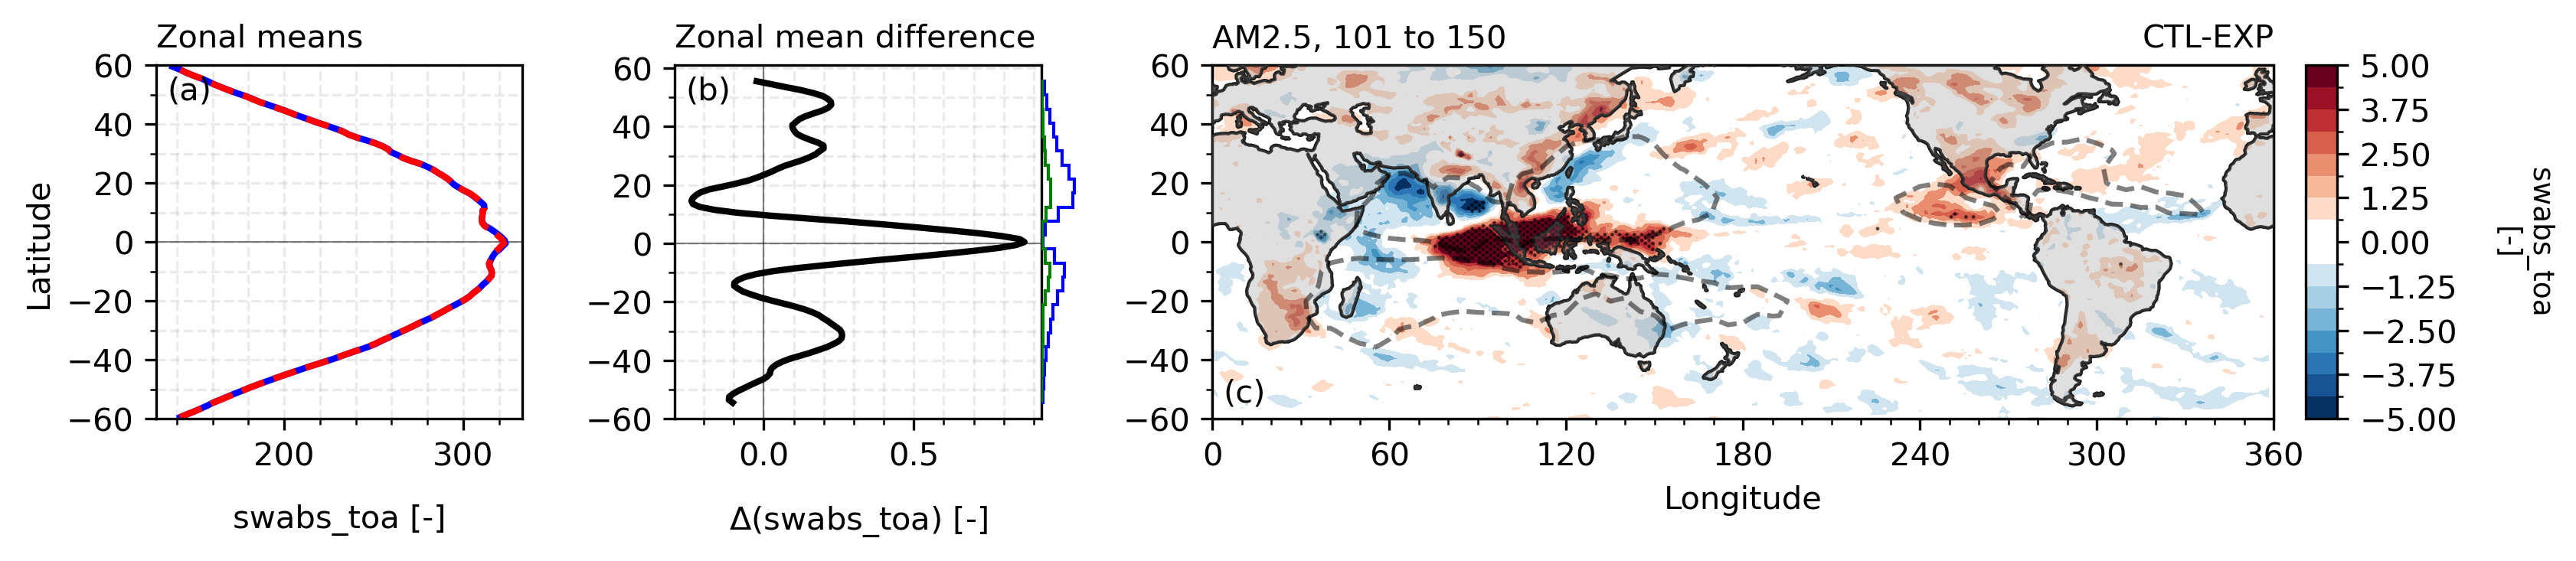

In [137]:
if plane == 'xy':
    xy_plot(model, data, median, stipple, field, experiments=experiments, years=years, months=months, ci=ci,
            extent=extent, vertical_level=level, contour_levels=16, domain_average=True, extrema=[-5, 5], dpi=300, 
            stipple_color='dark', cmap_white_fraction=0.1, outliers=True, mask_over_land=False, 
            coarsen_factor=coarsen_factor, savefig=False, track_overlay=True)

elif plane == 'yz':
    yz_plot(model, data, median, stipple, field, years=years, months=months, ci=ci,
            extent=extent, contour_levels=18, domain_average=True, extrema=[-0.5, 0.5], dpi=300, 
            stipple_color='dark', cmap_white_fraction=0.1, outliers=True, savefig=False)

CTL1990s ['/projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s-type_atmos-var_precip-mean_month-resample-full-101_150.nc', '/projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s-type_atmos-var_precip-mean_month-resample-full-101_200.nc'] None
Level: None
Experiment CTL1990s --> file: /projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s-type_atmos-var_precip-mean_month-resample-full-101_200.nc

Level: None
Experiment CTL1990s --> file: /projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s-type_atmos-var_precip-mean_month-resample-full-101_150.nc

CTL1990s_swishe ['/projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s_swishe-type_atmos-var_precip-mean_month-resample-full-101_150.nc', '/projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s_swishe-type_atmos-var_precip-mean_month-resample-full-101_200.nc'] None
Level: None
Experiment CTL1990s_swishe --> file: /projects/GEOCLIM/gr7610/analysis/model_

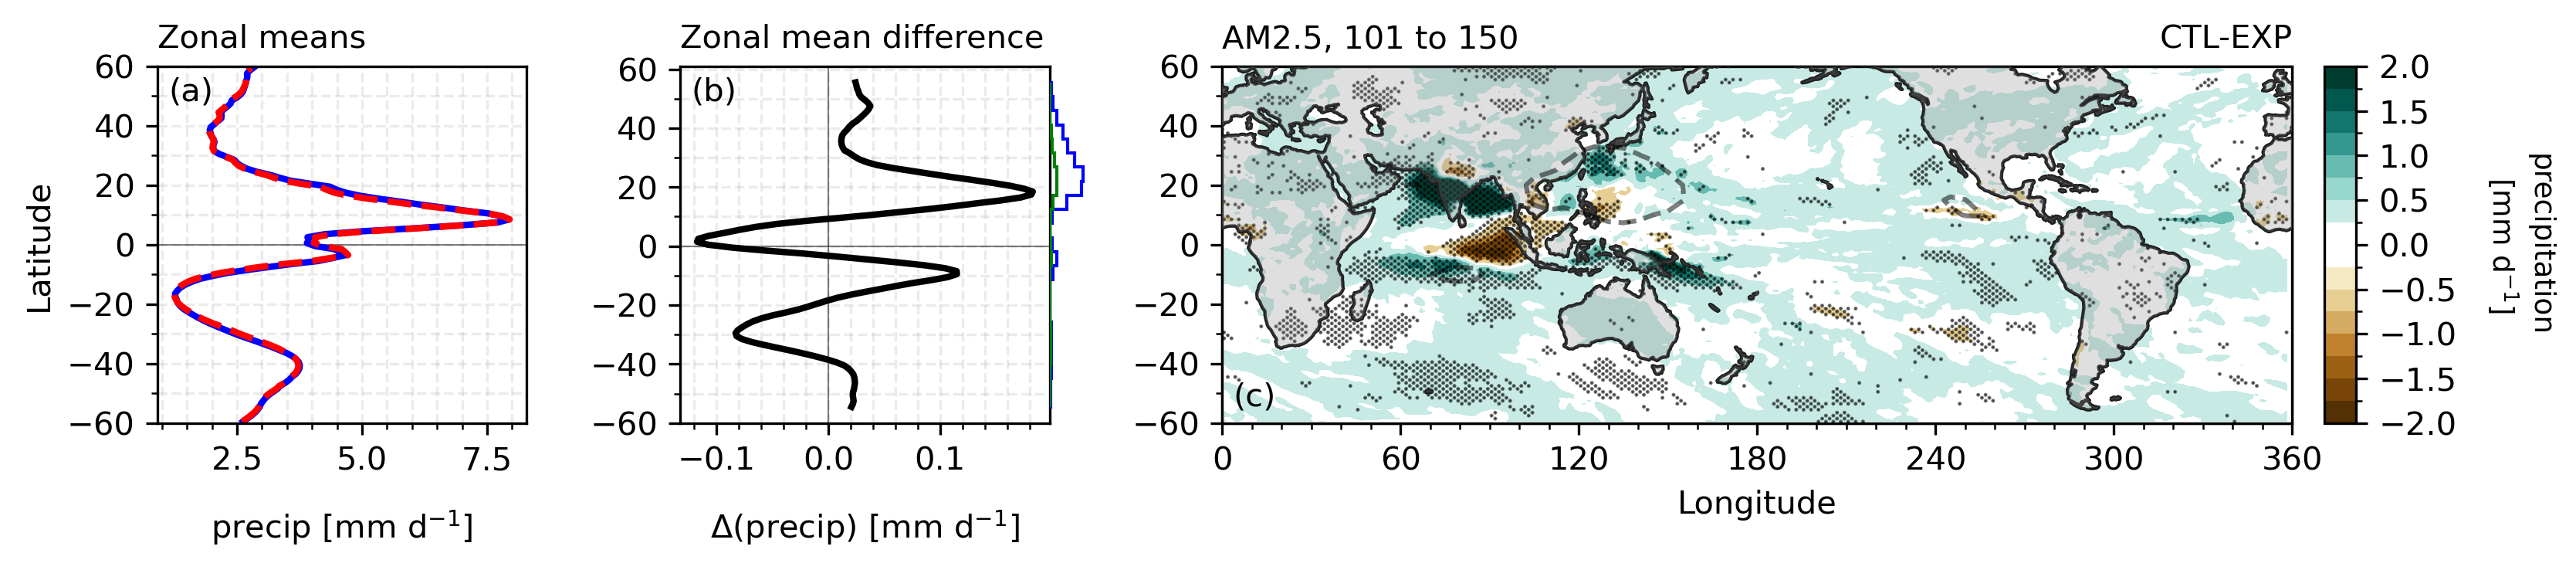

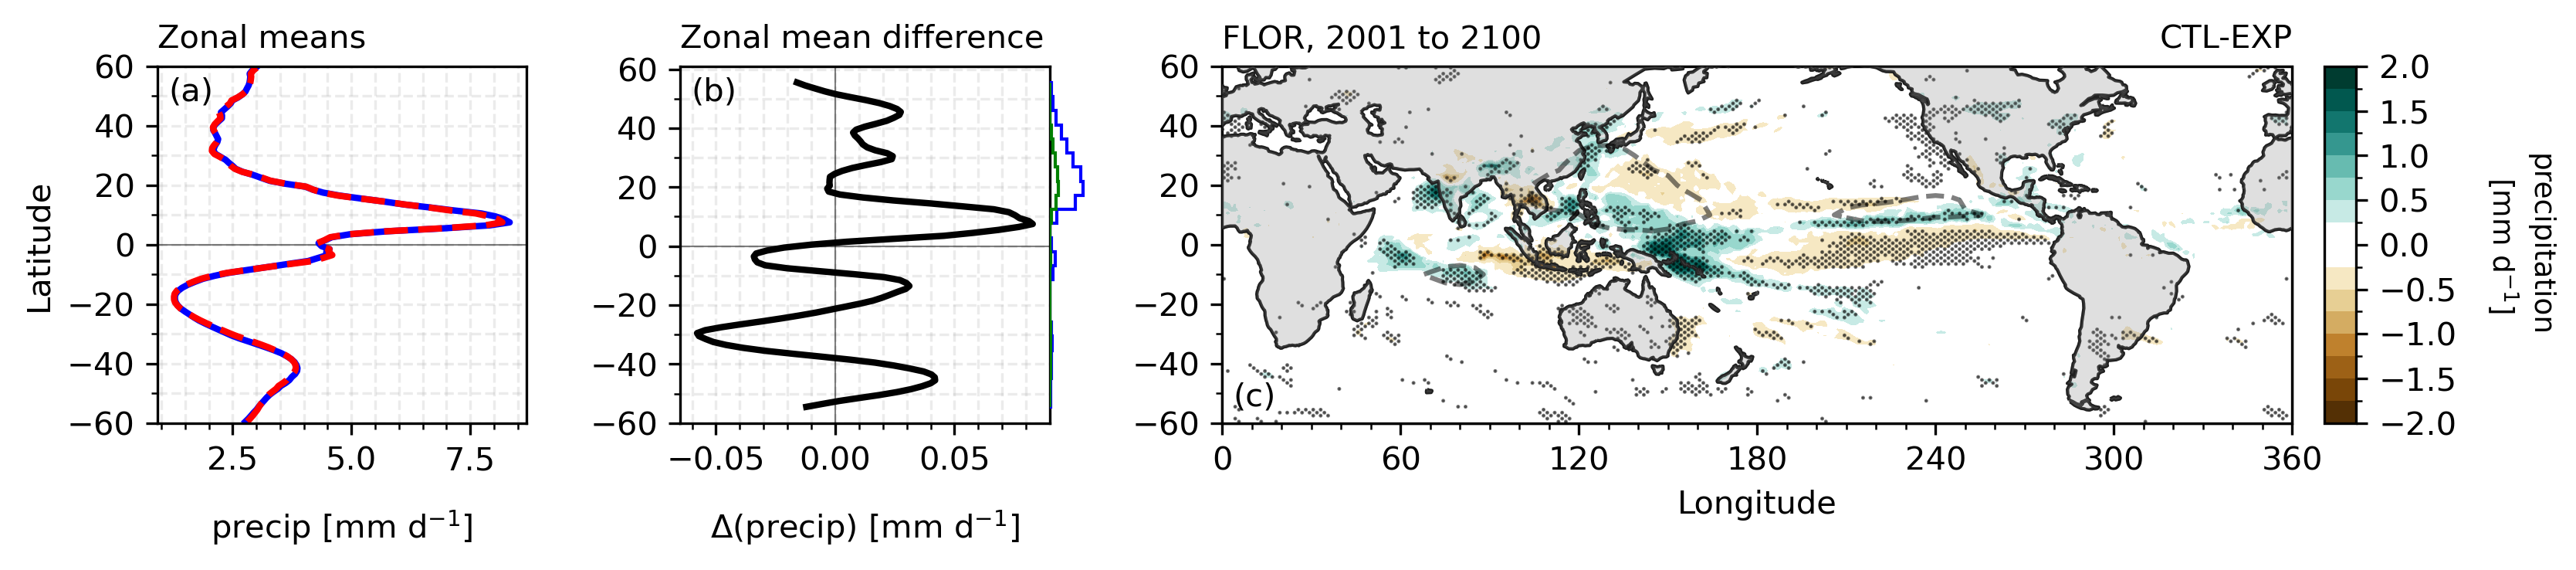

In [25]:
field_extrema = {'netrad_toa': (-5, 5),
                 'swabs_toa': (-10, 10),
                 'olr': (-10, 10),
                 'net_lw': (-10, 10),
                 'net_sw': (-10, 10),
                 'shflx': (-10, 10),
                 'q_atm': (-50, 50),
                 'precip': (-2, 2),
                 'p-e': (-2, 2),
                 'lp': (-50, 50),
                 'temp': (-1, 1),
                 't_surf': (-1, 1),
                 'WVP': (-2, 2)}

for model in ['AM2.5', 'FLOR']:
    for month_range in [(6, 9)]:
        for field in ['precip']:
            level = None
            domain = 'atmos'
            extent = [0, 359, -60, 60]
            years = [2001, 2100] if model in ['FLOR'] else [101, 150]
            ci = 0.95
            plane = 'xy'
            coarsen_factor = [2, 2, 1]
            experiments = ['CTL1990s_FA', 'CTL1990s_swishe_FA'] if model in ['FLOR'] else ['CTL1990s', 'CTL1990s_swishe']
            
            data, stipple, median_mask, median, delta, ci_min, ci_max = main(model, field, experiments=experiments, vertical_level=level, domain=domain,
                                                                             month_range=month_range, plane=plane, extent=extent, 
                                                                             coarsen_factor=coarsen_factor, N=1000, ci=ci, years=years)
            
            for experiment in data.keys():
                for k, v in data[experiment].items():
                    data[experiment][k].name = k
                data[experiment] = xr.merge(data[experiment].values())
                
            if plane == 'xy':
                xy_plot(model, data, median, stipple, field, experiments=experiments, years=years, months=month_range, ci=ci,
                        extent=extent, vertical_level=level, contour_levels=16, domain_average=True, extrema=field_extrema[field], dpi=300, 
                        stipple_color='dark', cmap_white_fraction=0.1, outliers=True, mask_over_land=False, 
                        coarsen_factor=coarsen_factor, savefig=False, track_overlay=True)